In [1]:
import glob
import time
import numpy
import crowdsource
import regions
import numpy as np
from functools import cache
from astropy.convolution import convolve, Gaussian2DKernel
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
from astropy.modeling.fitting import LevMarLSQFitter
from astropy import wcs
from astropy import table
from astropy import stats
from astropy import units as u
from astropy.nddata import NDData
from astropy.io import fits
from scipy import ndimage
import requests
import requests.exceptions
import urllib3
import urllib3.exceptions
from photutils.detection import DAOStarFinder, IRAFStarFinder
from photutils.psf import IntegratedGaussianPRF, extract_stars, EPSFStars, EPSFModel
try:
    # version >=1.7.0, doesn't work: the PSF is broken
    from photutils.psf import PSFPhotometry, IterativePSFPhotometry, SourceGrouper
except:
    # version 1.6.0, which works
    from photutils.psf import BasicPSFPhotometry as PSFPhotometry, IterativelySubtractedPSFPhotometry as IterativePSFPhotometry, DAOGroup as SourceGrouper
try:
    from photutils.background import MMMBackground, MADStdBackgroundRMS, MedianBackground, Background2D, LocalBackground
except:
    from photutils.background import MMMBackground, MADStdBackgroundRMS, MedianBackground, Background2D
    from photutils.background import MMMBackground as LocalBackground

from photutils.psf import EPSFBuilder
from photutils.psf import extract_stars

import warnings
from astropy.utils.exceptions import AstropyWarning, AstropyDeprecationWarning
warnings.simplefilter('ignore', category=AstropyWarning)
warnings.simplefilter('ignore', category=AstropyDeprecationWarning)

from crowdsource import crowdsource_base
from crowdsource.crowdsource_base import fit_im, psfmod

from astroquery.svo_fps import SvoFps

import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'

import os
print("Importing webbpsf", flush=True)
import webbpsf
from webbpsf.utils import to_griddedpsfmodel
import datetime

import scipy
import scipy.ndimage
import scipy.spatial
from scipy.spatial import KDTree


Importing webbpsf


In [2]:
basepath = '/blue/adamginsburg/adamginsburg/jwst/brick/'

In [3]:
import importlib as imp
imp.reload(crowdsource)
from crowdsource import crowdsource_base
imp.reload(crowdsource.crowdsource_base)
from crowdsource.crowdsource_base import fit_im, psfmod
from webbpsf.utils import to_griddedpsfmodel

In [4]:
filt = filtername = 'f410m'

In [5]:
im1 = fits.open(f'{basepath}/F410M/pipeline/jw02221001001_07101_00024_nrcblong_destreak_o001_crf.fits')
obsdate = im1[0].header['DATE-OBS']
module = 'nrcb'

In [6]:
has_downloaded = False
ntries = 0
while not has_downloaded:
    try:
        nrc = webbpsf.NIRCam()
        nrc.load_wss_opd_by_date(f'{obsdate}T00:00:00')
        nrc.filter = filt
        if module in ('nrca', 'nrcb'):
            if 'F4' in filt.upper():
                nrc.detector = f'{module.upper()}5' # I think NRCA5 must be the "long" detector?
            else:
                nrc.detector = f'{module.upper()}1' #TODO: figure out a way to use all 4?
            grid = nrc.psf_grid(num_psfs=16, all_detectors=False, verbose=True, save=True)
        else:
            grid = nrc.psf_grid(num_psfs=16, all_detectors=True, verbose=True, save=True)
        has_downloaded = True
    except (urllib3.exceptions.ReadTimeoutError, requests.exceptions.ReadTimeout, requests.HTTPError) as ex:
        print(f"Failed to build PSF: {ex}", flush=True)
        raise
    except Exception as ex:
        print(ex, flush=True)
        if ntries > 10:
            # avoid infinite loops
            raise ValueError("Failed to download PSF, probably because of an error listed above")
        else:
            raise
            continue


MAST OPD query around UTC: 2022-08-28T00:00:00.000
                        MJD: 59819.0

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022082702-NRCA3_FP1-1.fits
	Date (MJD):	 59817.7488
	Delta time:	 -1.2512 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022082902-NRCA3_FP1-1.fits
	Date (MJD):	 59819.7687
	Delta time:	 0.7687 days
User requested choosing OPD time closest in time to 2022-08-28T00:00:00.000, which is R2022082902-NRCA3_FP1-1.fits, delta time 0.769 days
Importing and format-converting OPD from /orange/adamginsburg/jwst/webbpsf-data/MAST_JWST_WSS_OPDs/R2022082902-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point

Running instrument: NIRCam, filter: F410M
  Running detector: NRCB5
    Position 1/16: (0, 0) pixels
    Position 1/16 centroid: (201.50624611033805, 201.04491630614913)
    Position 2/16: (0, 682) pixels
    Position 2/16 centroid: (201.53563193116167, 201.0039664

In [7]:
ww = wcs.WCS(im1[1].header)

module = 'nrcb'
data = im1['SCI'].data[:400,:400]
err = im1['ERR'].data[:400,:400]
#wht = im1['WHT'].data[:400,:400]
dq = im1['DQ'].data[:400, :400]

In [8]:
im1.info()

Filename: /blue/adamginsburg/adamginsburg/jwst/brick//F410M/pipeline/jw02221001001_07101_00024_nrcblong_destreak_o001_crf.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     362   ()      
  1  SCI           1 ImageHDU       127   (2048, 2048)   float32   
  2  ERR           1 ImageHDU        10   (2048, 2048)   float32   
  3  DQ            1 ImageHDU        11   (2048, 2048)   uint32   
  4  AREA          1 ImageHDU         9   (2048, 2048)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (2048, 2048)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (2048, 2048)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (2048, 2048)   float32   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [39963B]   


In [9]:
import sys
sys.path.append(f'{basepath}/analysis')
import crowdsource_catalogs_long
import importlib
importlib.reload(crowdsource_catalogs_long)
from crowdsource_catalogs_long import WrappedPSFModel, get_uncertainty

Starting crowdsource_catalogs_long
Importing webbpsf
2024-07-25T13:38:10.638454: Done with imports
2024-07-25T13:38:10.640736: Starting crowdsource_catalogs_long
2024-07-25T13:38:10.641589: Importing webbpsf
2024-07-25T13:38:10.642460: Done with imports


In [10]:
psf_model = WrappedPSFModel(grid)

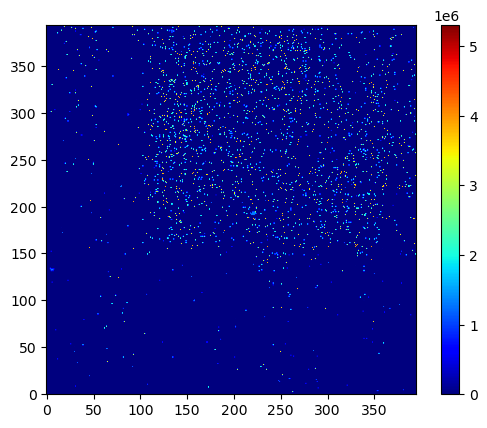

In [11]:
pl.imshow(im1['DQ'].data[5:400,5:400], cmap='jet');
pl.colorbar();

# Start tests

In [12]:
dq, weight, bad = get_uncertainty(err, data, wht=None, dq=dq)

In [15]:
data.shape, data.size, bad.sum()

((400, 400), 160000, 4305)

In [16]:
from scipy.spatial import KDTree

# crowdsource

In [17]:
results  = fit_im(np.nan_to_num(data), psf_model, weight=weight,
                  dq=dq,
                  nskyx=0, nskyy=0, refit_psf=False, verbose=True)
stars, modsky, skymsky, psf = results
residual = data - modsky
model = modsky
result = stars = Table(stars)
stars['x'], stars['y'] = stars['y'], stars['x']

Starting subregion iterations
Subregion iteration 0 finished; dt=31.212965965270996
threshold=5, median fluxunc=0.041848745197057724, median flux=63.17973709106445 time=31.31274676322937
Extension None, iteration  1, found   2347 sources;    1 close and  512 faint sources removed.
Starting subregion iterations
Subregion iteration 0 finished; dt=37.76230192184448
threshold=5, median fluxunc=0.033089153468608856, median flux=88.68136596679688 time=37.82810354232788
Extension None, iteration  2, found    658 sources;   11 close and  184 faint sources removed.
Starting subregion iterations
Subregion iteration 0 finished; dt=71.65375137329102
threshold=5, median fluxunc=0.042693842202425, median flux=62.08741760253906 time=71.99211883544922
Extension None, iteration  3, found   2444 sources;  153 close and  214 faint sources removed.
Starting subregion iterations
Subregion iteration 0 finished; dt=89.18997931480408
threshold=5, median fluxunc=0.04470382630825043, median flux=55.188179016113

In [18]:
len(stars)

7748

In [19]:
Table(stars[:3])

<Table length=3>
        x                  y            flux    passno      dx          dy       dflux        qf       rchi2    fracflux  fluxlbs   dfluxlbs    fwhm   spread_model dspread_model  fluxiso          xiso                 yiso            flags       sky   
     float64            float64       float32  float64   float32     float32    float32    float32    float32   float32   float32   float32   float32    float32       float32     float32        float64              float64           int32     float32 
------------------ ----------------- --------- ------- ----------- ----------- --------- ----------- --------- --------- --------- --------- --------- ------------ ------------- --------- -------------------- -------------------- ----------- ---------
178.94266785681248            -0.499 3530.4114     0.0 0.039304633 0.066215836 110.91515 0.036390256 13.993084 0.5030084 3593.7764 142.03673 2.8561604 0.0018535256  0.0028446042  3165.355 -0.09377610334173679    0.648613984380146 -2143813631 10.361073
 43.82290392745296 3.381327091390762   169.605     0.0 0.043505967  0.06346474   6.55298  0.33002234 8.2854395 0.8475654  160.7798 7.3044252  2.854855  0.005693078  0.0023382353    90.866   0.8932452324888992  -0.3243718423561804 -2143813631 10.797654
  84.0485594603745 2.845970249000198 477.02563     0.0 0.019137993 0.026997553 8.5576105  0.33013394  6.210312 0.9261183  469.8489  9.568021 2.8552597  0.008271933  0.0012549502 342.45135   0.3462692330382377 -0.11337253238129917 -2143813631 10.418806

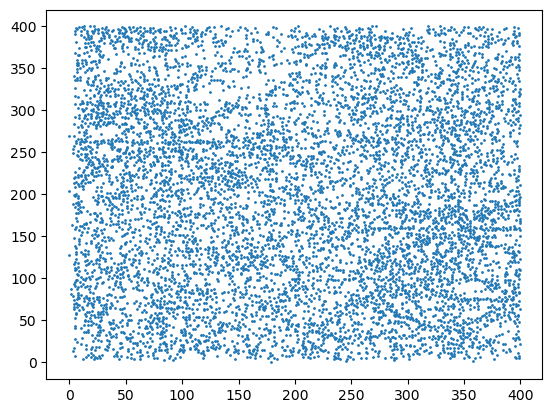

In [20]:
pl.scatter(result['x'], result['y'], s=1)

In [21]:
dist, ind = KDTree(np.array([result['x'], result['y']]).T).query(np.array([result['x'], result['y']]).T, 2) 
close_neighbor = ind[:,1][dist[:,1] < 1]

len(close_neighbor), len(stars)

(0, 7748)

### Default

### Histograms

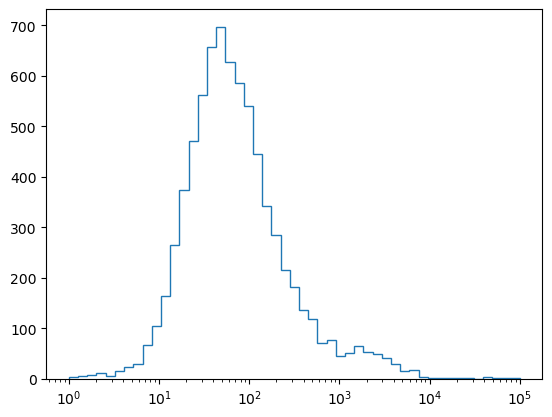

In [22]:
pl.hist(result['flux'], bins=np.logspace(0,5), histtype='step')
#pl.hist(result_g['flux_init'], bins=np.logspace(0,5), histtype='step')
pl.xscale('log');

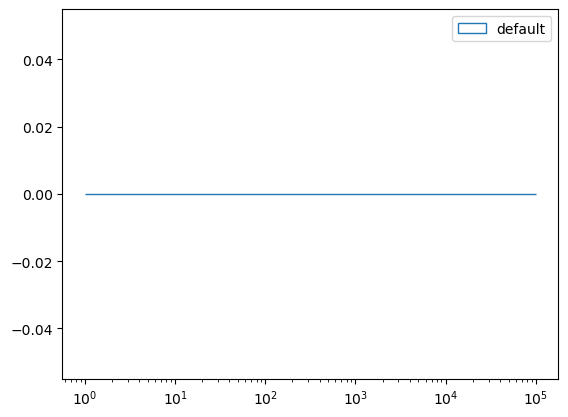

In [23]:
pl.hist(result['flux'][close_neighbor], bins=np.logspace(0,5), histtype='step', label='default')
pl.xscale('log');
pl.legend(loc='best');

In [24]:
    np.unique(dq)

array([         0,          3,         17,       2049,      16385,
            32769,      65536,      81921,    1114113,    1116161,
          1117187,    1311745,    1312769,    1327105,    1328129,
          4194304,    4194307,    4194321,    4196353,    4210689,
          4227073,    4259840,    5310465, 2151153665, 2155347969],
      dtype=uint32)

In [25]:
good = (stars['qf'] > 0.9) & (stars['fracflux'] > 0.75)

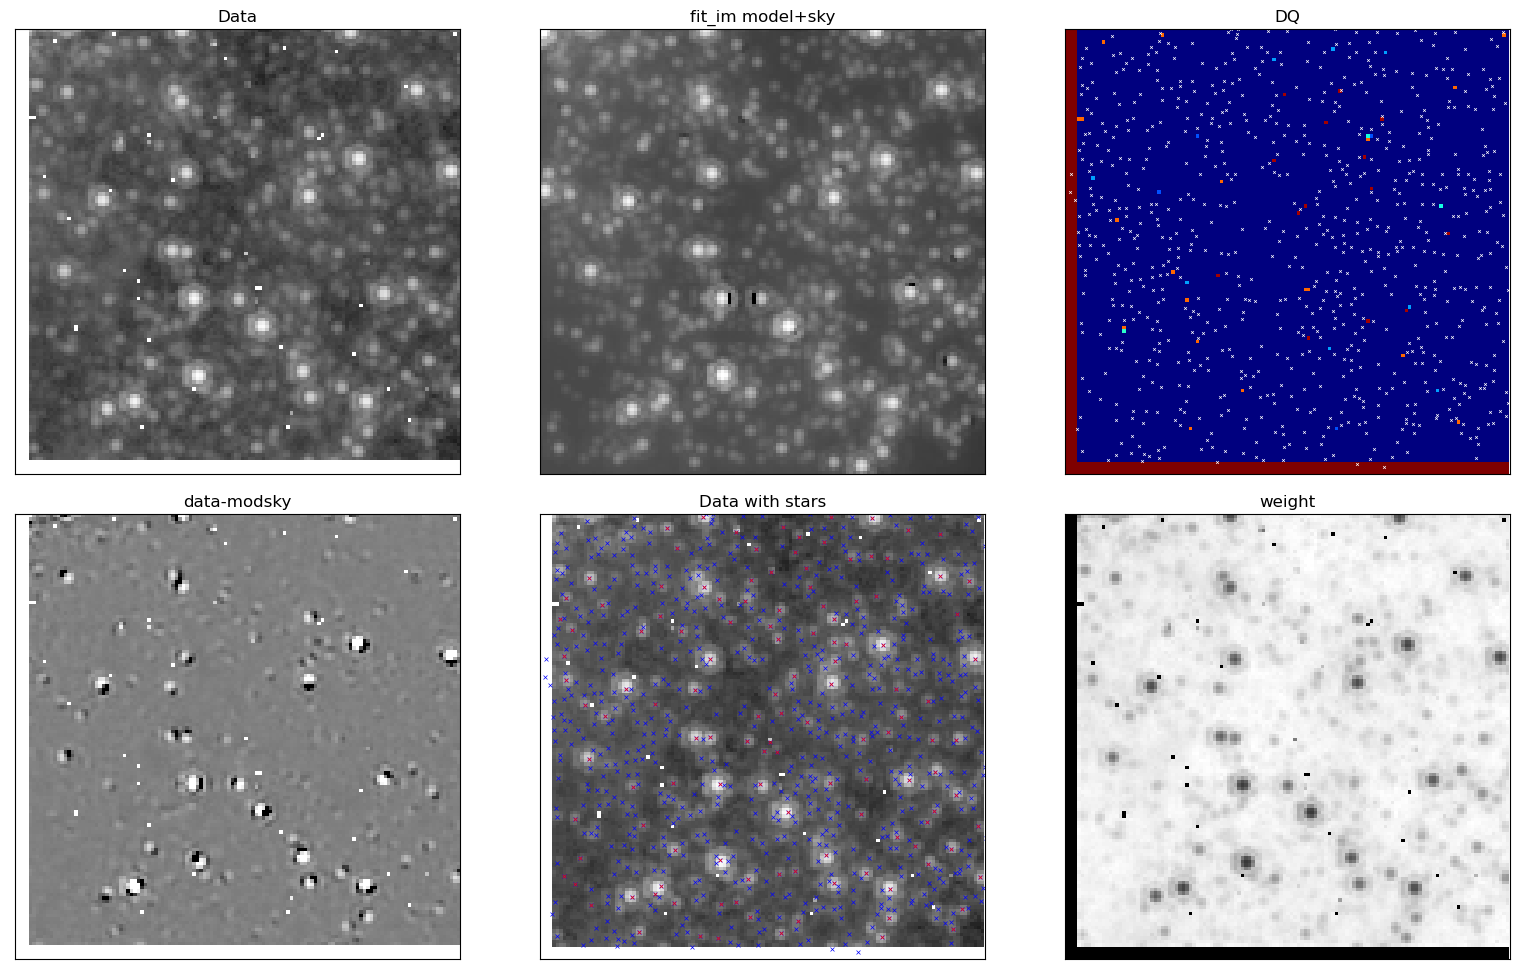

In [26]:
pl.figure(figsize=(16,10))
pl.subplot(2,3,1).imshow(data[:128,:128], norm=simple_norm(data[:256,:256], stretch='log', max_percent=99.95, min_percent=0.5), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("Data")
pl.subplot(2,3,2).imshow(modsky[:128,:128], norm=simple_norm(modsky[:256,:256], stretch='log', max_percent=99.95, min_percent=0.5), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("fit_im model+sky")
pl.subplot(2,3,4).imshow((data-modsky)[:128,:128], norm=simple_norm((data-modsky)[:256,:256], stretch='asinh',
                                                                    max_percent=99.5, min_percent=0.5), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("data-modsky")
pl.subplot(2,3,5).imshow(data[:128,:128], norm=simple_norm(data[:256,:256], stretch='log', max_percent=99.95, min_percent=0.5), cmap='gray')
pl.subplot(2,3,5).scatter(stars['x'], stars['y'], marker='x', color='b', s=8, linewidth=0.5)
pl.subplot(2,3,5).scatter(stars['x'][good], stars['y'][good], marker='x', color='r', s=6, linewidth=0.5)
pl.xticks([]); pl.yticks([]); pl.title("Data with stars");
pl.axis([0,128,0,128])
pl.subplot(2,3,3).imshow((dq)[:128,:128], norm=simple_norm((dq), stretch='log', min_cut=0, max_cut=5310465), cmap='jet')
pl.subplot(2,3,3).scatter(stars['x'], stars['y'], marker='x', color='w', s=4, linewidth=0.5)
pl.axis([0,128,0,128])
pl.xticks([]); pl.yticks([]); pl.title("DQ");
pl.subplot(2,3,6).imshow(weight[:128,:128], norm=simple_norm(weight[:128,:128], stretch='asinh', min_percent=5, max_percent=99.95), cmap='gray')
#pl.subplot(2,3,6).scatter(stars['x'], stars['y'], marker='x', color='r', s=4, linewidth=0.5)
pl.axis([0,128,0,128])
pl.xticks([]); pl.yticks([]); pl.title("weight");
pl.suptitle("");
pl.tight_layout();

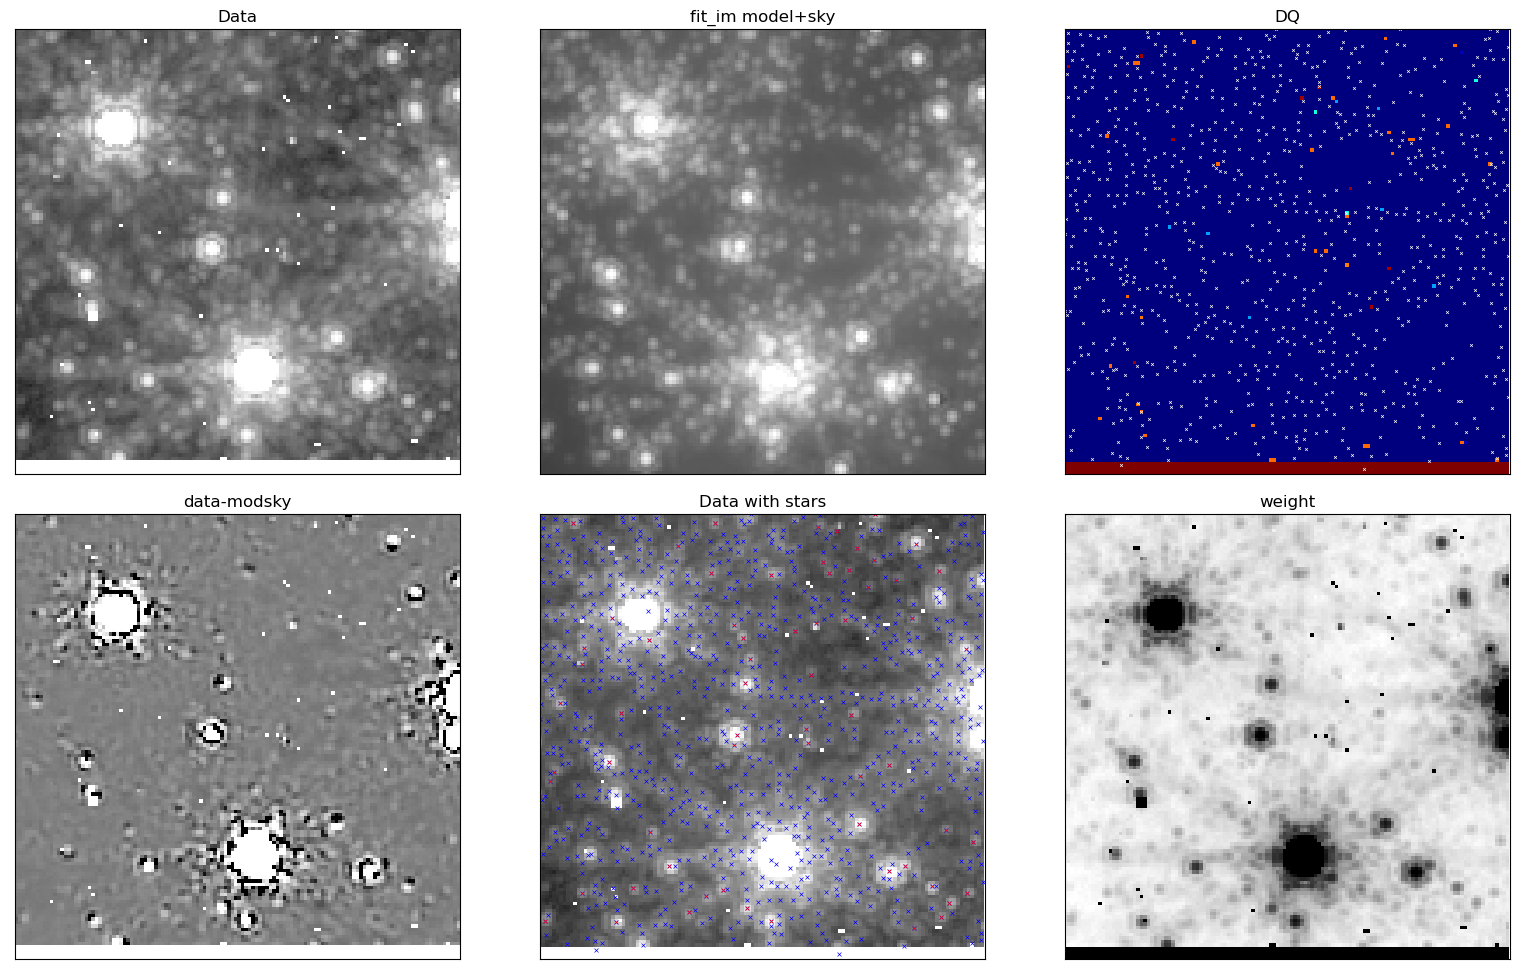

In [27]:
pl.figure(figsize=(16,10))
pl.subplot(2,3,1).imshow(data[:128,-128:], norm=simple_norm(data[:256,:256], stretch='log', max_percent=99.95, min_percent=0.5), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("Data")
pl.subplot(2,3,2).imshow(modsky[:128,-128:], norm=simple_norm(modsky[:256,:256], stretch='log', max_percent=99.95, min_percent=0.5), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("fit_im model+sky")
pl.subplot(2,3,4).imshow((data-modsky)[:128,-128:], norm=simple_norm((data-modsky)[:256,:256], stretch='asinh', max_percent=99.5, min_percent=0.5), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("data-modsky")
pl.subplot(2,3,5).imshow(data[:128,-128:], norm=simple_norm(data[:256,:256], stretch='log', max_percent=99.95, min_percent=0.5), cmap='gray')
pl.subplot(2,3,5).scatter(stars['x']-(400-128), stars['y'], marker='x', color='b', s=8, linewidth=0.5)
pl.subplot(2,3,5).scatter(stars['x'][good]-(400-128), stars['y'][good], marker='x', color='r', s=6, linewidth=0.5)
pl.xticks([]); pl.yticks([]); pl.title("Data with stars");
pl.axis([0,128,0,128])
pl.subplot(2,3,3).imshow((dq)[:128,-128:], norm=simple_norm((dq), stretch='log', min_cut=0, max_cut=5310465), cmap='jet')
pl.subplot(2,3,3).scatter(stars['x']-(400-128), stars['y'], marker='x', color='w', s=4, linewidth=0.5)
pl.axis([0,128,0,128])
pl.xticks([]); pl.yticks([]); pl.title("DQ");
pl.subplot(2,3,6).imshow(weight[:128,-128:], norm=simple_norm(weight[:128,-128:], stretch='asinh', min_percent=5, max_percent=99.95), cmap='gray')
#pl.subplot(2,3,6).scatter(stars['x'], stars['y'], marker='x', color='r', s=4, linewidth=0.5)
pl.axis([0,128,0,128])
pl.xticks([]); pl.yticks([]); pl.title("weight");
pl.suptitle("");
pl.tight_layout();

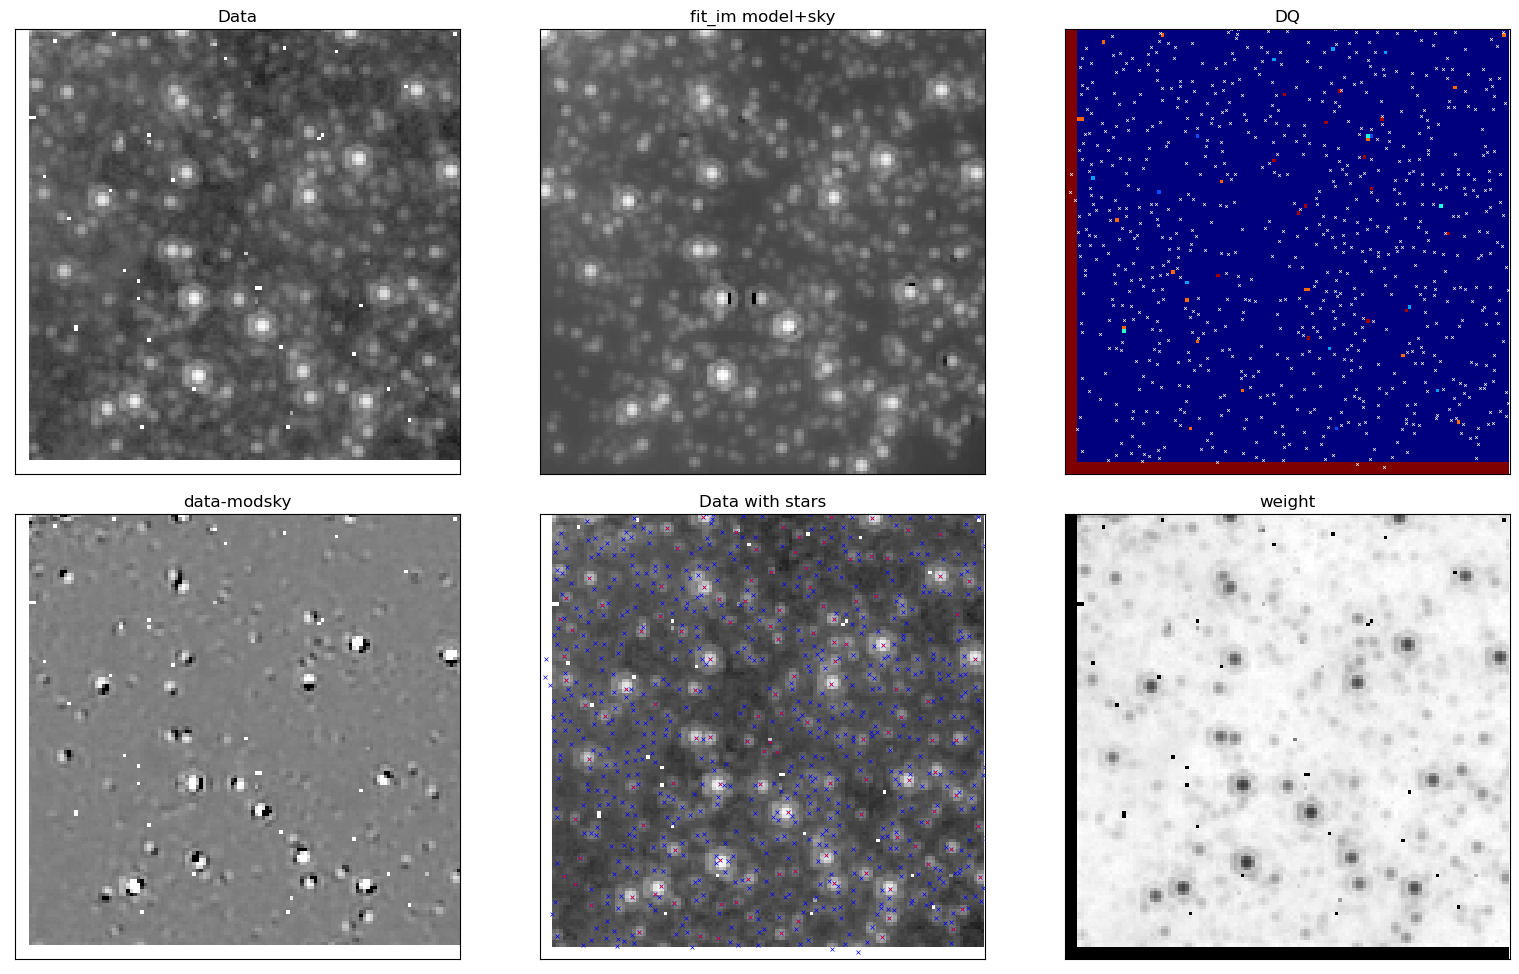

In [28]:
pl.figure(figsize=(16,10))
pl.subplot(2,3,1).imshow(data[:128,:128], norm=simple_norm(data[:256,:256], stretch='log', max_percent=99.95, min_percent=0.5), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("Data")
pl.subplot(2,3,2).imshow(modsky[:128,:128], norm=simple_norm(modsky[:256,:256], stretch='log', max_percent=99.95, min_percent=0.5), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("fit_im model+sky")
pl.subplot(2,3,4).imshow((data-modsky)[:128,:128], norm=simple_norm((data-modsky)[:256,:256], stretch='asinh', max_percent=99.5, min_percent=0.5), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("data-modsky")
pl.subplot(2,3,5).imshow(data[:128,:128], norm=simple_norm(data[:256,:256], stretch='log', max_percent=99.95, min_percent=0.5), cmap='gray')
pl.subplot(2,3,5).scatter(stars['x'], stars['y'], marker='x', color='b', s=8, linewidth=0.5)
pl.subplot(2,3,5).scatter(stars['x'][good], stars['y'][good], marker='x', color='r', s=4, linewidth=0.5)
pl.xticks([]); pl.yticks([]); pl.title("Data with stars");
pl.axis([0,128,0,128])
pl.subplot(2,3,3).imshow((dq)[:128,:128], norm=simple_norm((dq), stretch='log', min_cut=0, max_cut=5310465), cmap='jet')
pl.subplot(2,3,3).scatter(stars['x'], stars['y'], marker='x', color='w', s=4, linewidth=0.5)
pl.axis([0,128,0,128])
pl.xticks([]); pl.yticks([]); pl.title("DQ");
pl.subplot(2,3,6).imshow(weight[:128,:128], norm=simple_norm(weight[:128,:128], stretch='asinh', min_percent=5, max_percent=99.95), cmap='gray')
#pl.subplot(2,3,6).scatter(stars['x'], stars['y'], marker='x', color='r', s=4, linewidth=0.5)
pl.axis([0,128,0,128])
pl.xticks([]); pl.yticks([]); pl.title("weight");
pl.suptitle("");
pl.tight_layout();

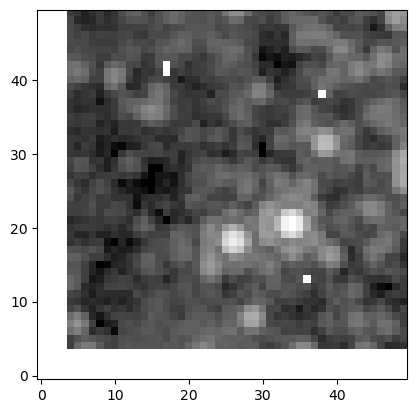

In [44]:
pl.imshow(data[:50, :50], norm=simple_norm(data[:50, :50], stretch='log', max_percent=99.95, min_percent=0.5), cmap='gray')

#### Super Zoom

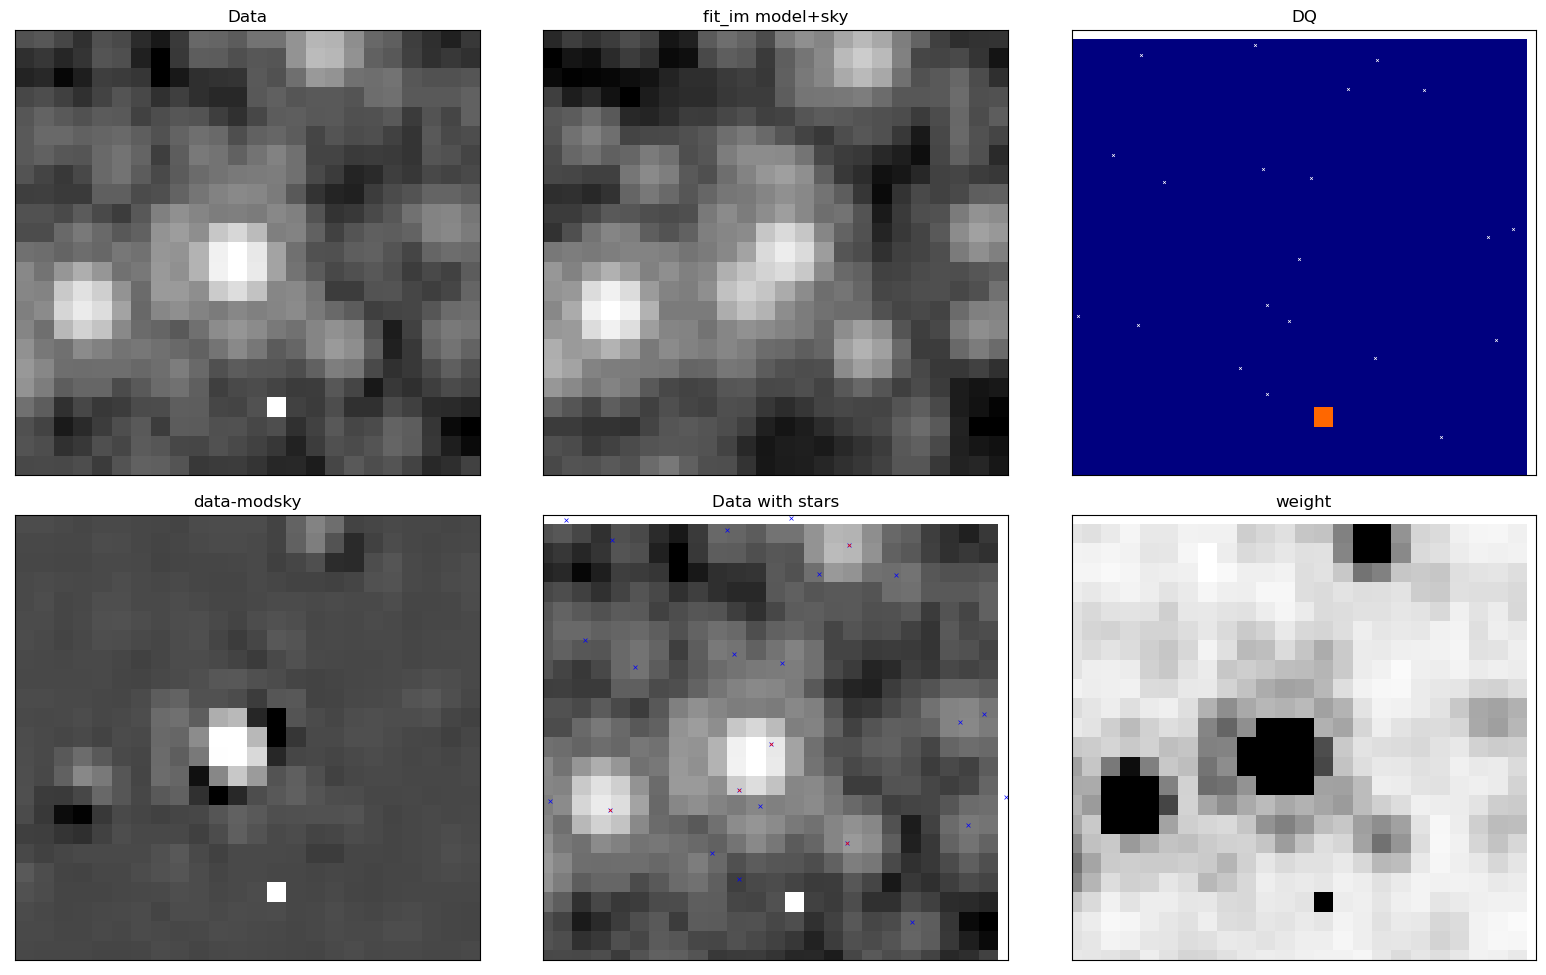

In [48]:
# SUPER zoom in
slcs = slice(10, 33), slice(23, 47)

pl.figure(figsize=(16,10))
pl.subplot(2,3,1).imshow(data[slcs], norm=simple_norm(data[slcs], stretch='log', max_percent=99.95, min_percent=0.5), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("Data")
pl.subplot(2,3,2).imshow(modsky[slcs], norm=simple_norm(modsky[slcs], stretch='log', max_percent=99.95, min_percent=0.5), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("fit_im model+sky")
pl.subplot(2,3,4).imshow((data-modsky)[slcs], norm=simple_norm((data-modsky)[slcs], stretch='asinh', max_percent=99.5, min_percent=0.5), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("data-modsky")
pl.subplot(2,3,5).imshow(data[slcs], norm=simple_norm(data[slcs], stretch='log', max_percent=99.95, min_percent=0.5), cmap='gray')
pl.subplot(2,3,5).scatter(stars['x']-slcs[1].start, stars['y']-slcs[0].start, marker='x', color='b', s=8, linewidth=0.5)
pl.subplot(2,3,5).scatter(stars['x'][good]-slcs[1].start, stars['y'][good]-slcs[0].start, marker='x', color='r', s=4, linewidth=0.5)
pl.xticks([]); pl.yticks([]); pl.title("Data with stars");
pl.axis([0,slcs[1].stop-slcs[1].start,0,slcs[0].stop-slcs[0].start])
pl.subplot(2,3,3).imshow((dq)[slcs], norm=simple_norm((dq), stretch='log', min_cut=0, max_cut=5310465), cmap='jet')
pl.subplot(2,3,3).scatter(stars['x']-slcs[1].start, stars['y']-slcs[0].start, marker='x', color='w', s=4, linewidth=0.5)
pl.axis([0,slcs[1].stop-slcs[1].start,0,slcs[0].stop-slcs[0].start])
pl.xticks([]); pl.yticks([]); pl.title("DQ");
pl.subplot(2,3,6).imshow(weight[slcs], norm=simple_norm(weight[slcs], stretch='asinh', min_percent=5, max_percent=99.95), cmap='gray')
#pl.subplot(2,3,6).scatter(stars['x'], stars['y'], marker='x', color='r', s=4, linewidth=0.5)
pl.axis([0,slcs[1].stop-slcs[1].start,0,slcs[0].stop-slcs[0].start])
pl.xticks([]); pl.yticks([]); pl.title("weight");
pl.suptitle("");
pl.tight_layout();

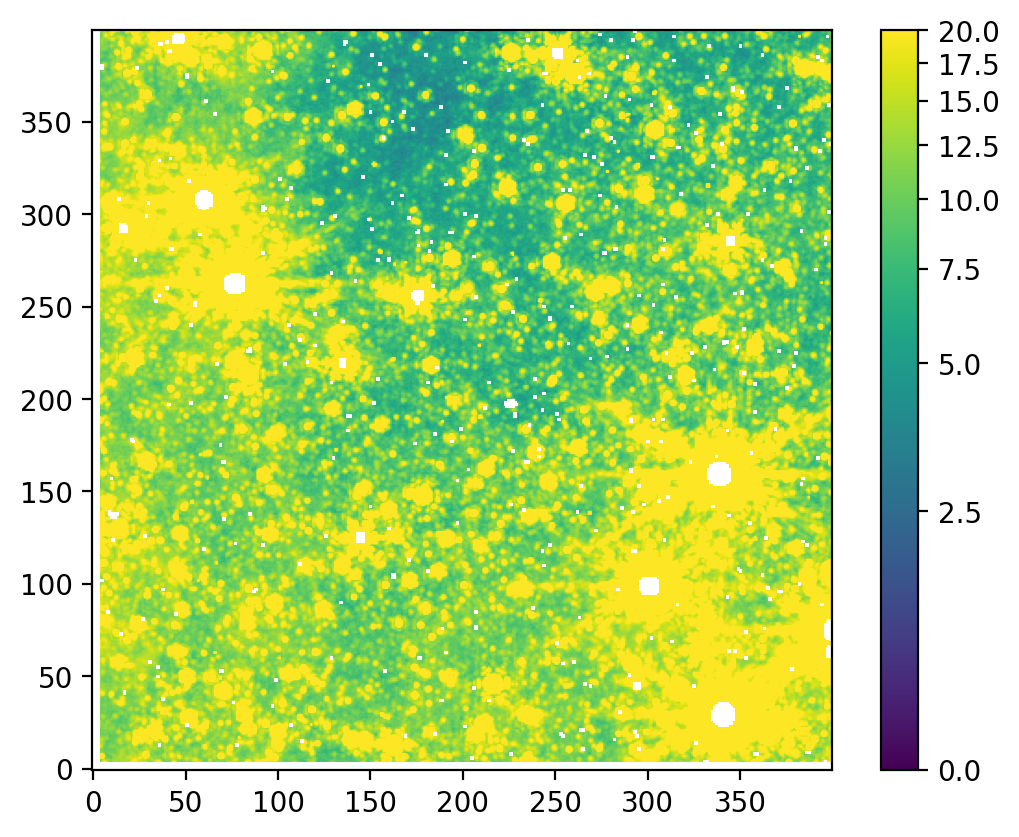

In [29]:
pl.figure(dpi=200)
pl.imshow(data, norm=simple_norm(data, min_cut=0, max_cut=20, stretch='asinh'))
pl.colorbar();

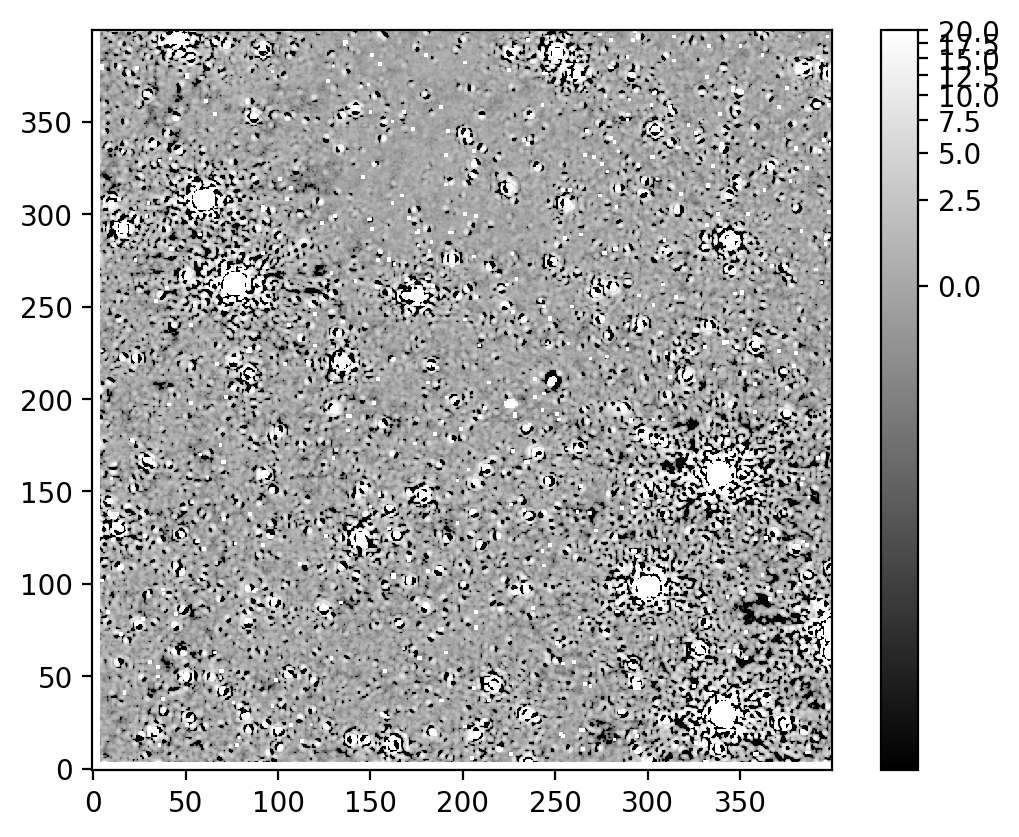

In [30]:
pl.figure(dpi=200)
pl.imshow(residual, norm=simple_norm(residual, min_cut=-2, max_cut=20, stretch='log'), cmap='gray')
pl.colorbar();

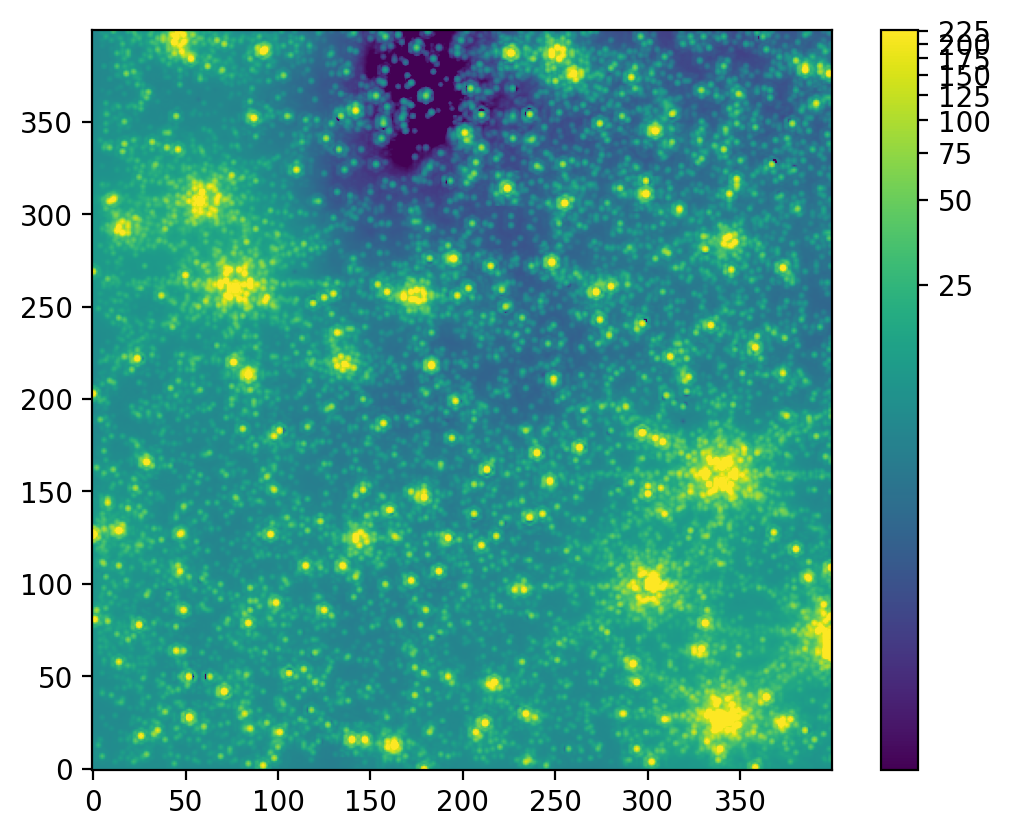

In [31]:
pl.figure(dpi=200)
pl.imshow(model, norm=simple_norm(model, min_percent=1, max_percent=99, stretch='log'))
pl.colorbar();

In [32]:
xl,xu,yl,yu = 100,300,200,400
slc = slice(yl,yu), slice(xl,xu)

(0.0, 200.0, 0.0, 200.0)

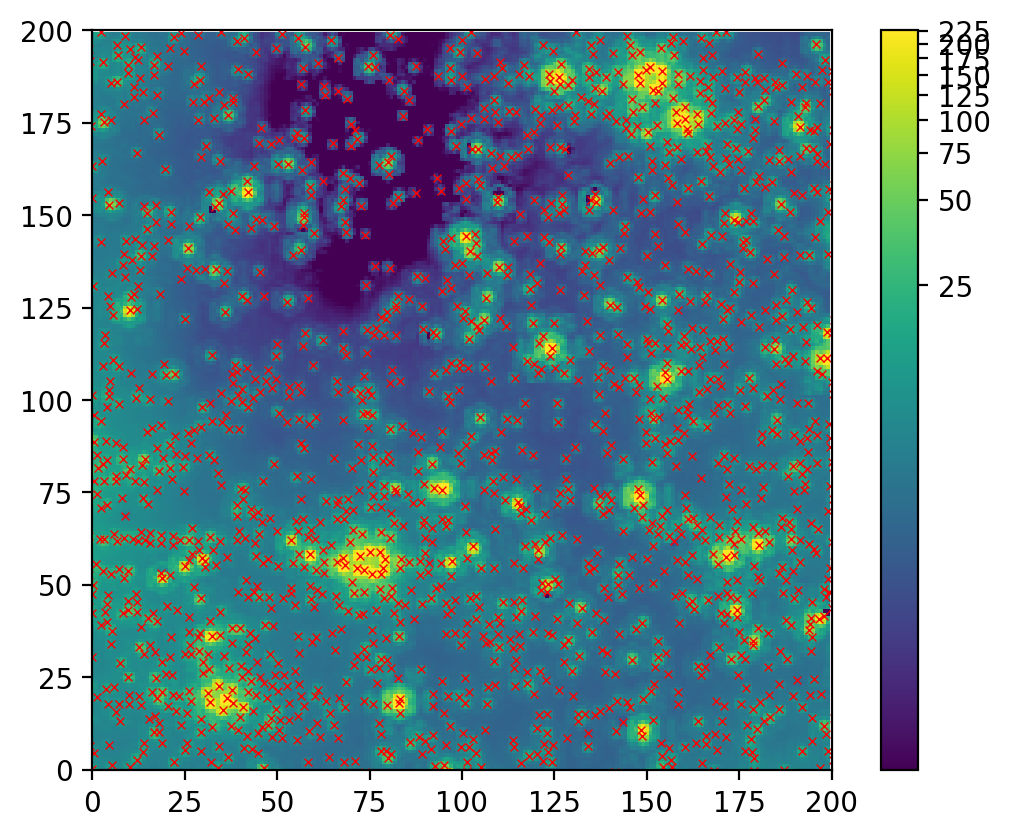

In [33]:
pl.figure(dpi=200)
pl.imshow(model[slc], norm=simple_norm(model, min_percent=1, max_percent=99, stretch='log'))
pl.colorbar();
pl.scatter(result['x']-xl, result['y']-yl, marker='x', color='r', linewidths=0.5, s=8)
pl.axis([0,200,0,200])

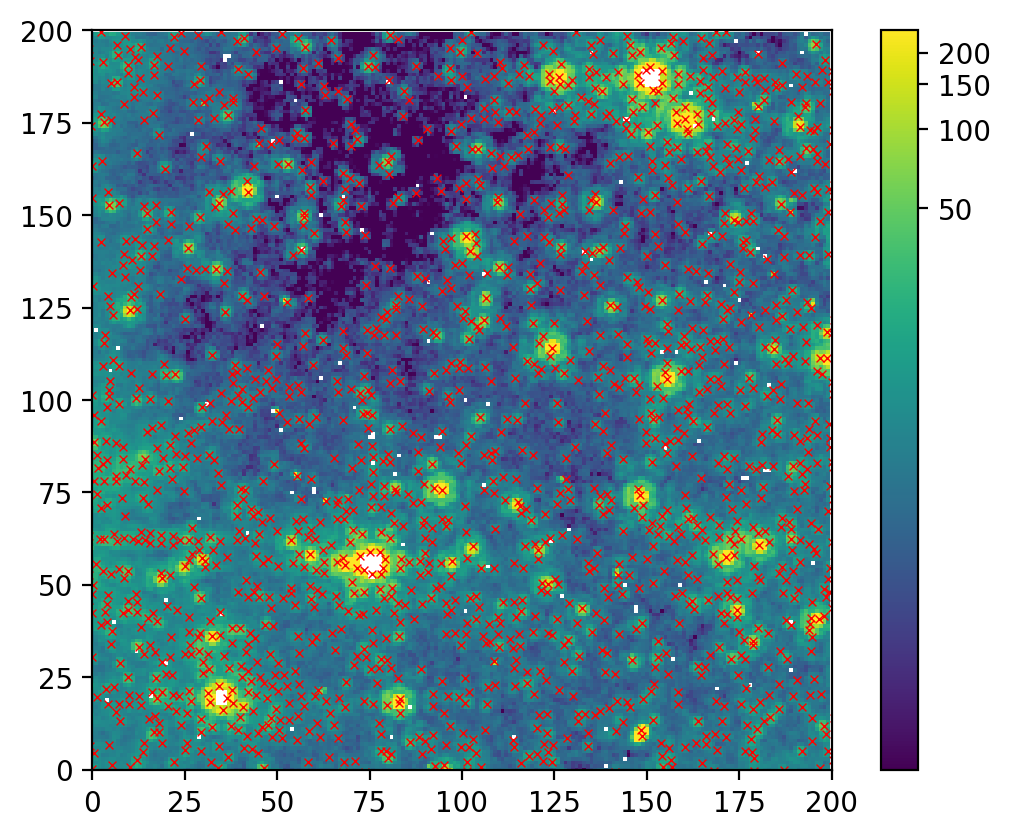

In [34]:
pl.figure(dpi=200)
pl.imshow(data[slc], norm=simple_norm(data, min_percent=1, max_percent=99, stretch='log'))
pl.colorbar();
pl.scatter(result['x']-xl, result['y']-yl, marker='x', color='r', linewidths=0.5, s=8)
pl.axis([0,200,0,200]);

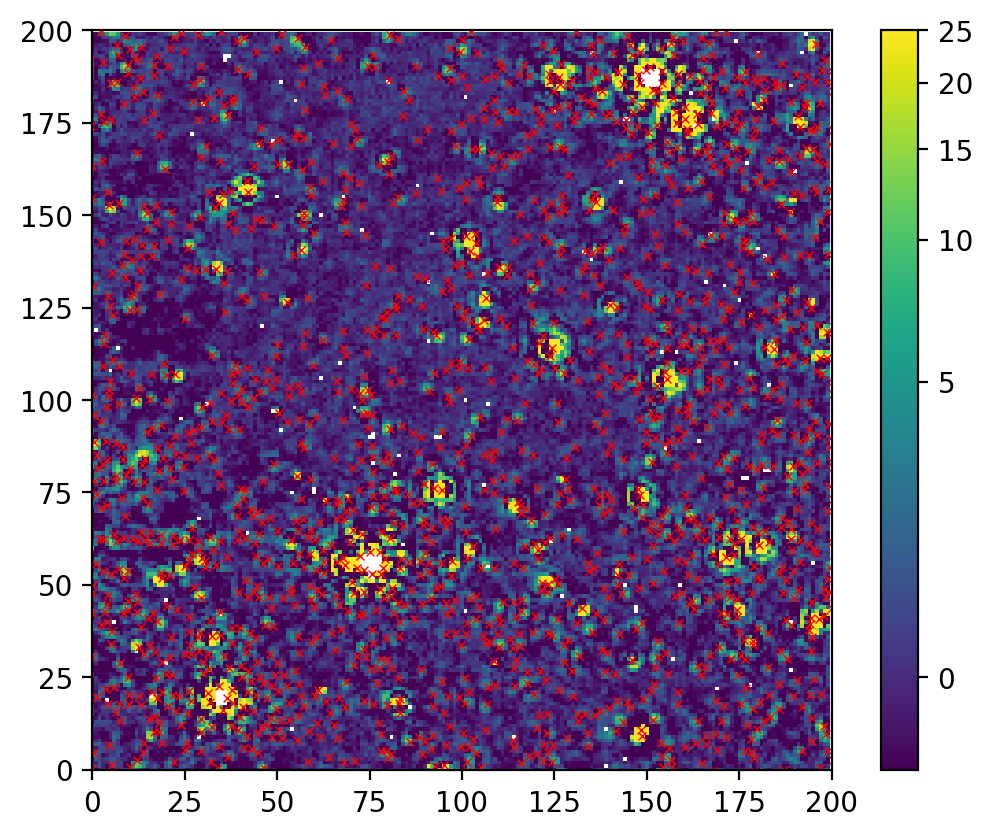

In [35]:
pl.figure(dpi=200)
pl.imshow(residual[slc], norm=simple_norm(residual, min_cut=-1, max_cut=25, stretch='asinh'))
pl.colorbar();
pl.scatter(result['x']-xl, result['y']-yl, marker='x', color='r', linewidths=0.5, s=8)
pl.axis([0,200,0,200]);

# Residual zoom

In [36]:
import sys
sys.path.append(f'{basepath}/analysis')
import plot_tools
import importlib as imp
imp.reload(plot_tools)
from plot_tools import diagnostic_stamps_by_mag_crowdsource
def diagnostic_stamps_by_mag(*args, **kwargs):
    return diagnostic_stamps_by_mag_crowdsource(*args, filtername=filtername, pixel_area=ww.celestial.proj_plane_pixel_area(), data=data, **kwargs)

/blue/adamginsburg/adamginsburg/jwst/brick//reduction/filtering.py:29: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


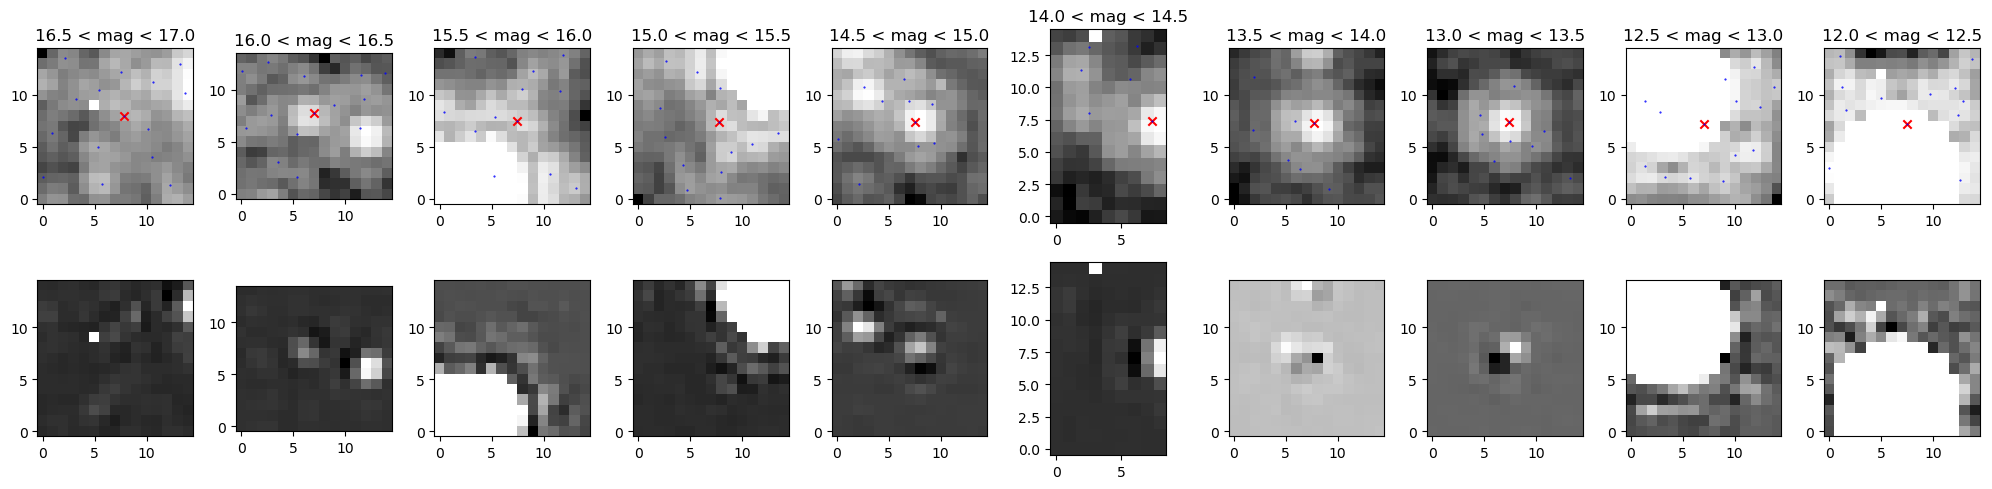

In [37]:
diagnostic_stamps_by_mag(result, residual)

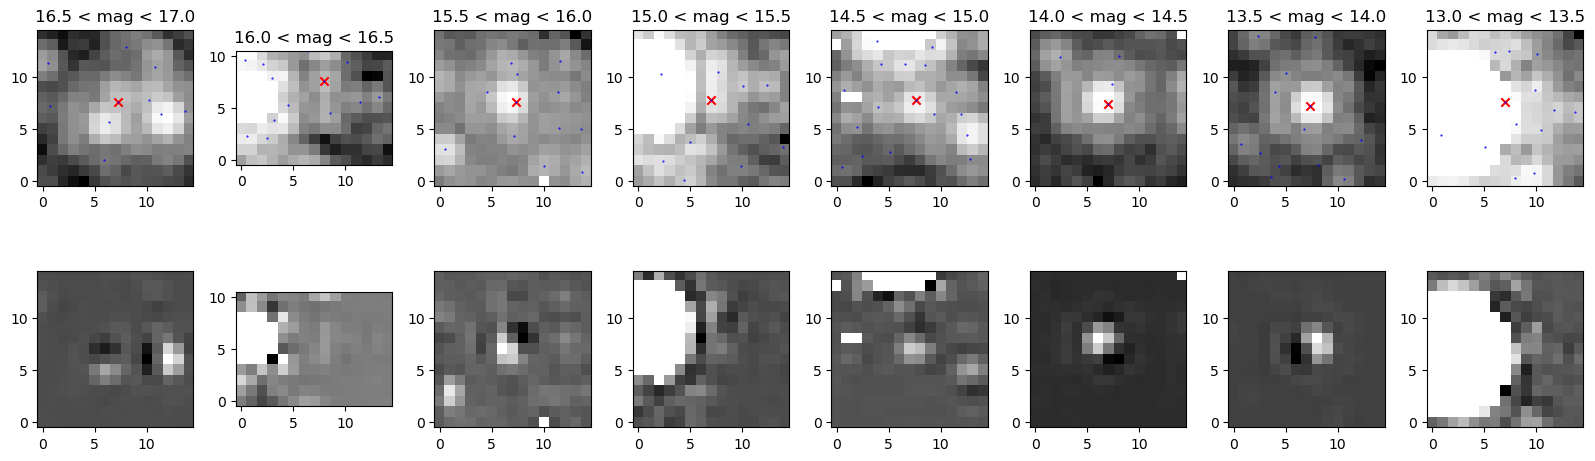

In [38]:
diagnostic_stamps_by_mag(result, residual, ind_offset=1)

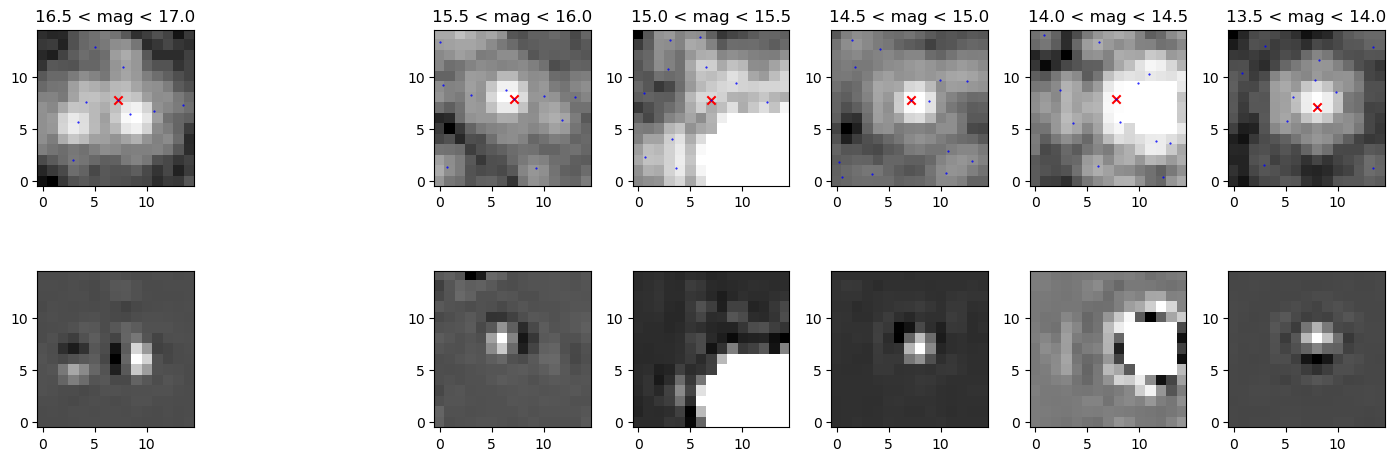

In [39]:
diagnostic_stamps_by_mag(result, residual, ind_offset=2)

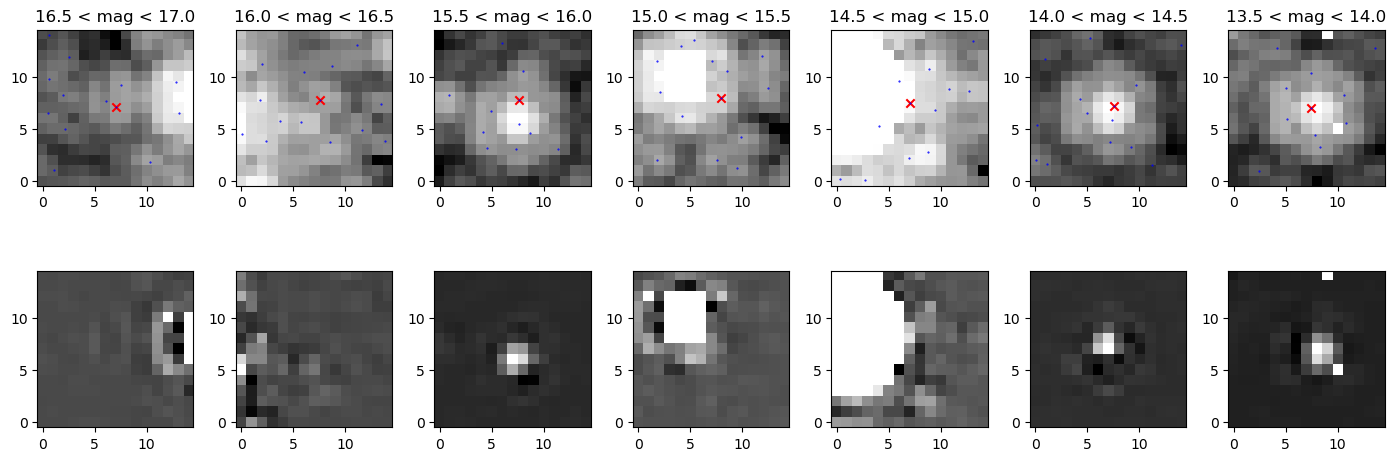

In [40]:
diagnostic_stamps_by_mag(result, residual, ind_offset=3)

# Really zoom in and see what's happening iteration-to-iteration

In [49]:
slcs = slice(10, 33), slice(23, 47)

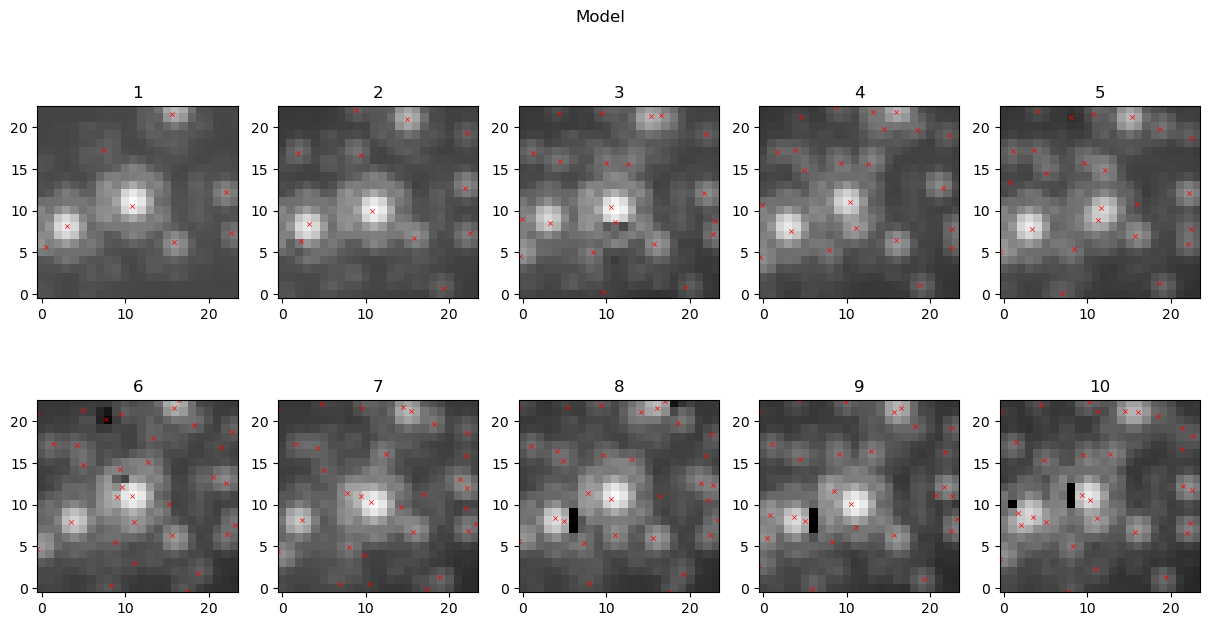

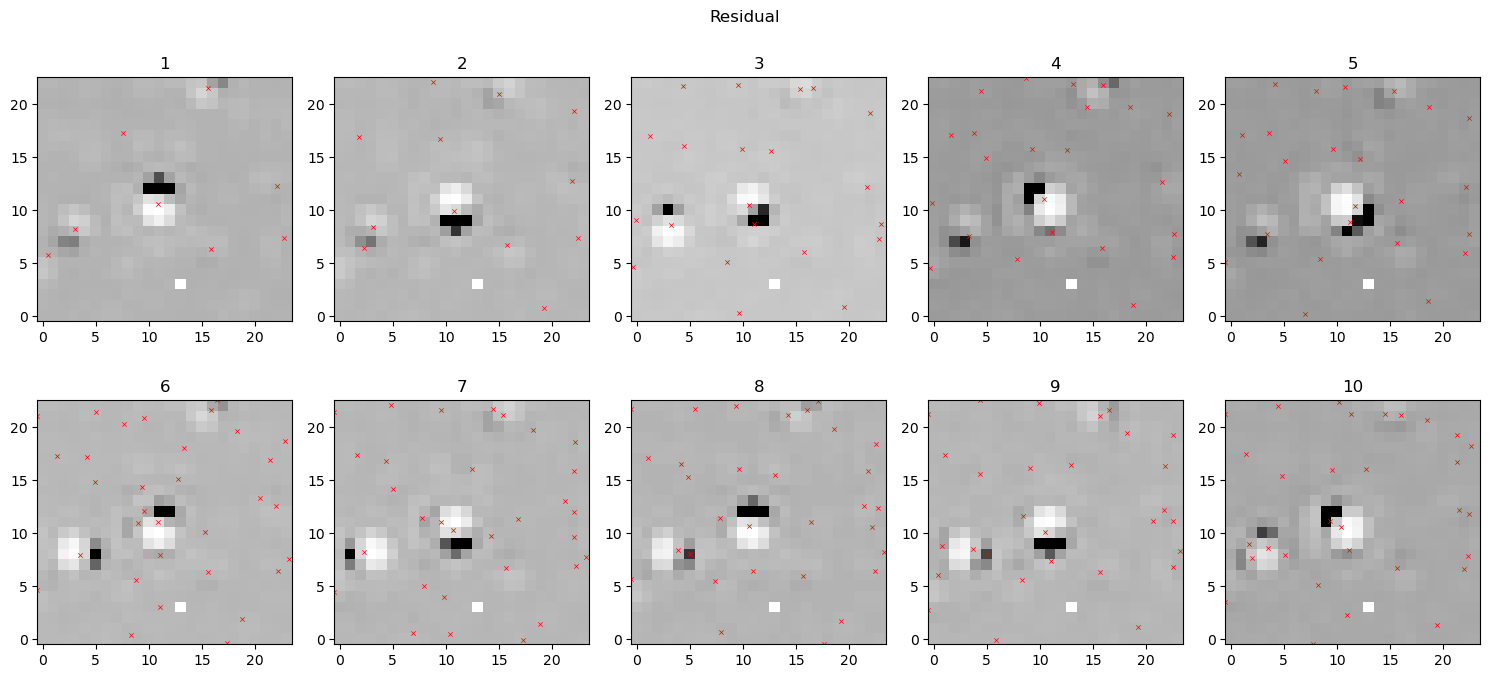

In [60]:
fig1 = pl.figure(figsize=(15, 7))
pl.suptitle("Model")

fig2 = pl.figure(figsize=(15, 7))

for ii in range(1, 11):
    data_superzoom = data[slcs]
    results_superzoom  = fit_im(np.nan_to_num(data)[slcs], psf_model, weight=weight[slcs],
                                dq=dq[slcs],
                                miniter=ii, maxiter=ii,
                      nskyx=0, nskyy=0, refit_psf=False, verbose=False)
    stars_superzoom, modsky_superzoom, skymsky_superzoom, psf_superzoom = results_superzoom
    residual_superzoom = data_superzoom - modsky_superzoom
    model_superzoom = modsky_superzoom
    result_superzoom = stars_superzoom = Table(stars_superzoom)
    stars_superzoom['x'], stars_superzoom['y'] = stars_superzoom['y'], stars_superzoom['x']
    
    ax = fig1.add_subplot(2, 5, ii)
    ax.imshow(modsky_superzoom, cmap='gray', norm=simple_norm(data[slcs], stretch='log', max_percent=99.95, min_percent=0.5))
    ax.scatter(stars_superzoom['x'], stars_superzoom['y'], marker='x', color='r', linewidth=0.5, s=10)
    ax.set_title(str(ii))
    
    ax = fig2.add_subplot(2, 5, ii)
    ax.imshow(data_superzoom - modsky_superzoom, cmap='gray', norm=simple_norm(data[slcs]-modsky_superzoom, stretch='log', max_percent=99.95, min_percent=0.5))
    ax.scatter(stars_superzoom['x'], stars_superzoom['y'], marker='x', color='r', linewidth=0.5, s=10)
    ax.set_title(str(ii))
    pl.suptitle("Residual")
    
pl.tight_layout()

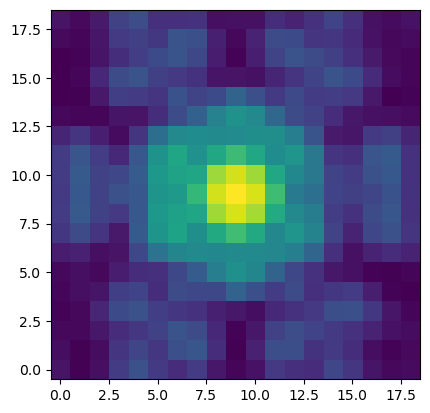

In [64]:
pl.imshow(psf_model(25, 25), norm=simple_norm(psf_model(25, 25), stretch='log', max_percent=99.95, min_percent=0.5))